In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

from keras.datasets import cifar10 

In [2]:
(train,_) , (test,_) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [3]:
print(train.shape[1:],test.shape)

(32, 32, 3) (10000, 32, 32, 3)


In [4]:
#normalizr the data sets 
train_norm = train.astype('float32')/255
test_norm = test.astype('float32')/255

In [5]:
#adding noise to the images 
def add_noise_and_clip_data(data):
   noise = np.random.normal(loc=0.0, scale=0.3, size=data.shape)
   data = data + noise
   data = np.clip(data, 0., 1.)
   return data

In [6]:
train_noise = add_noise_and_clip_data(train_norm)
test_noise = add_noise_and_clip_data(test_norm)

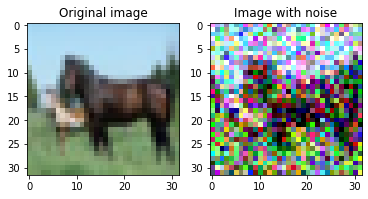

In [7]:
index = 12
plt.subplot(1,2,1)
plt.imshow(train[index])
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(train_noise[index])
plt.title('Image with noise')
plt.show()

In [8]:
from keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose, Activation, BatchNormalization, ReLU,Concatenate
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [9]:
#encoder function block
def encode(x, filters, kernel_size, strides=2):
    x = Conv2D(filters=filters, kernel_size=kernel_size,
                  strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

In [10]:
#decoder function block 
def decode(x,filters,kernel_size,strides=2):
    x = Conv2DTranspose(filters=filters,kernel_size = kernel_size,
                           strides = strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x 

In [11]:
# the convolutional layers (4) with downsampling and (1) without
def denoising_autoencoder():
    # the encoder
    inputs = Input(shape=train.shape[1:],name="inputs")
    conv1 = encode(inputs,32,3)
    conv2 = encode(conv1,64,3)
    conv3 = encode(conv2,128,3)
    conv4 = encode(conv3,256,3)
    conv5 = encode(conv4,256,3,1)
    
    # the decoder
    dconv1 = decode(conv5,256,3)
    merge1 = Concatenate()([dconv1,conv3])
    dconv2 = decode(merge1,128,3)
    merge2 = Concatenate()([dconv2,conv2])
    dconv3 = decode(merge2,64,3)
    merge3 = Concatenate()([dconv3,conv1])
    dconv4 = decode(merge3,32,3)
    
    dconv5 = Conv2DTranspose(filters=3,kernel_size=3,
                                padding='same')(dconv4)
    output = Activation('sigmoid',name='output')(dconv5)
    # dae - denoising auto encoder
    return Model(inputs,output,name='dae')

In [15]:
model = denoising_autoencoder()
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
checkpoint = ModelCheckpoint('model1.h5', verbose=1, save_best_only=True, save_weights_only=True)
model.summary()

Model: "dae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 16, 16, 32)   896         inputs[0][0]                     
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 16, 16, 32)   128         conv2d_15[0][0]                  
__________________________________________________________________________________________________
re_lu_27 (ReLU)                 (None, 16, 16, 32)   0           batch_normalization_27[0][0]     
________________________________________________________________________________________________

In [16]:
model.fit(train_noise, train_norm, validation_data = (test_noise,test_norm),
             epochs = 40, batch_size=128,
             callbacks = [checkpoint])

Epoch 1/40
391/391 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.6353
Epoch 00001: val_loss improved from inf to 0.00812, saving model to model1.h5
391/391 [==============================] - 8s 20ms/step - loss: 0.0092 - accuracy: 0.6353 - val_loss: 0.0081 - val_accuracy: 0.6877
Epoch 2/40
390/391 [============================>.] - ETA: 0s - loss: 0.0065 - accuracy: 0.7041
Epoch 00002: val_loss improved from 0.00812 to 0.00634, saving model to model1.h5
391/391 [==============================] - 7s 19ms/step - loss: 0.0065 - accuracy: 0.7041 - val_loss: 0.0063 - val_accuracy: 0.7295
Epoch 3/40
389/391 [============================>.] - ETA: 0s - loss: 0.0062 - accuracy: 0.7149
Epoch 00003: val_loss improved from 0.00634 to 0.00596, saving model to model1.h5
391/391 [==============================] - 7s 19ms/step - loss: 0.0062 - accuracy: 0.7150 - val_loss: 0.0060 - val_accuracy: 0.7302
Epoch 4/40
390/391 [============================>.] - ETA: 0s - loss: 0.00

Epoch 30/40
390/391 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.7525
Epoch 00030: val_loss did not improve from 0.00550
391/391 [==============================] - 7s 19ms/step - loss: 0.0046 - accuracy: 0.7525 - val_loss: 0.0058 - val_accuracy: 0.7397
Epoch 31/40
389/391 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.7535
Epoch 00031: val_loss did not improve from 0.00550
391/391 [==============================] - 7s 19ms/step - loss: 0.0046 - accuracy: 0.7536 - val_loss: 0.0059 - val_accuracy: 0.7402
Epoch 32/40
390/391 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.7529
Epoch 00032: val_loss did not improve from 0.00550
391/391 [==============================] - 7s 18ms/step - loss: 0.0046 - accuracy: 0.7529 - val_loss: 0.0059 - val_accuracy: 0.7282
Epoch 33/40
389/391 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.7543
Epoch 00033: val_loss did not improve from 0.00550
391/391 [===

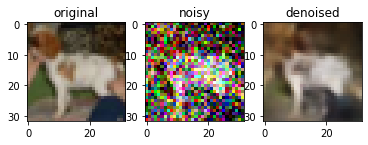

In [17]:
predicted = model.predict(test_noise)

idx = 12
plt.subplot(1,3,1)
plt.imshow(test[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(test_noise[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(predicted[idx])
plt.title('denoised')
plt.show()

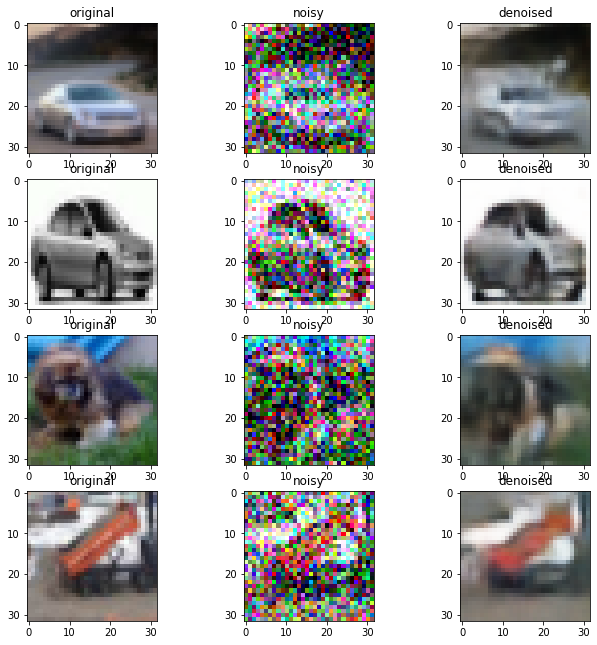

In [18]:
from random import randint

fig,ax = plt.subplots(4,3,figsize=(11,11))

for i in range(4):
    idx = randint(0,10000)
#     plt.subplot(2,3,i+1,figsize=(7,7))
    ax[i,0].imshow(test[idx])
    ax[i,0].title.set_text('original')
#     fig.title('original')
#     plt.subplot(2,3,i+2,figsize=(7,7))
    ax[i,1].imshow(test_noise[idx])
    ax[i,1].title.set_text('noisy')
#     fig.title('noisy')
#     plt.subplot(2,3,i+3,figsize=(7,7))
    ax[i,2].imshow(predicted[idx])
    ax[i,2].title.set_text('denoised')
#     fig.title('denoised')
plt.show()

In [20]:
scores = model.evaluate(test_noise,test_norm,verbose=1)

313/313 [==============================] - 1s 4ms/step - loss: 0.0060 - accuracy: 0.7347


In [21]:
print(model.metrics_names,scores)

['loss', 'accuracy'] [0.005971851758658886, 0.7346727252006531]
